In [1]:
from Bio import SeqIO
import glob
import pandas as pd
from itertools import combinations, product
import numpy as np
from scipy import stats 

# Input files
lcb_map = 'rumino0.tree_to_LCB.txt' # Maps tree to LCB file
pop_map = '../../Data/Clusters/rumino_0.000355362.txt.cluster.tab.txt' # ClusterPop Clusters
msa_file = '../alignment_blocks/rumino0.core.fasta' # Multiple sequence alignment

p1 = 0.0138272139869 # Average nucleotide diversity of population I
p0 = 0.00521122600799 # Average nucleotide diversity of population II
p0vp1 = 0.018270053640144713 # Average nucleotide diversity between I and II
alpha = 0.95 # Cutoff for determining whether a putative sweep region is significantly lower in diversity than expected

LCB_table = pd.read_table(lcb_map)
total_alignment = {s.id : str(s.seq) for s in SeqIO.parse(msa_file, 'fasta')}

df = pd.read_table(pop_map)
pop0 = [strain.replace('_', '').replace('.','').replace('--', '_') for strain in df[df['Cluster_ID'] == 0].Strain]
pop1 = [strain.replace('_', '').replace('.','').replace('--', '_') for strain in df[df['Cluster_ID'] == 0.1].Strain]
pop2 = [strain.replace('_', '').replace('.','').replace('--', '_') for strain in df[df['Cluster_ID'] == 0.2].Strain]

# Outdf is the dataframe of nucleotide diversity per block
outdf = pd.read_csv('pi_join_info.csv', index_col=0)
outdf['block'] = outdf.index

outdf['Length'] = outdf.end - outdf.start
outdf['Midpoint'] = outdf.start + (outdf.end - outdf.start) // 2
outdf['Start'] = outdf['start']
outdf['End'] = outdf['end']
outdf = outdf.sort_values('Midpoint')
outdf = outdf.merge(LCB_table)


In [9]:
def concatenate_windows(sweepdf, length_cutoff=1000):
    i = 0
    final_df = pd.DataFrame()
    current_end = None
    blocks = []
    for index, row in sweepdf.iterrows():
        if not current_end:
            current_end = row['End']
            blocks.append(index)
        elif row['Start'] <= current_end:
            blocks.append(index)

        else: 
            if len(blocks) > 0:
                if sweepdf.loc[max(blocks), 'End'] - sweepdf.loc[min(blocks), 'Start'] >= length_cutoff:
                    block_begin = min(blocks)
                    block_end = max(blocks)
                    final_df.loc[i, 'Start'] = sweepdf.loc[min(blocks), 'Start']
                    final_df.loc[i, 'End'] = sweepdf.loc[max(blocks), 'End']
                    final_df.loc[i, 'Start tree'] = min(blocks)
                    final_df.loc[i, 'End tree'] = max(blocks)
                    i += 1
            blocks = []
        current_end = row['End']
        
    if len(blocks) > 0:
        if sweepdf.loc[max(blocks), 'End'] - sweepdf.loc[min(blocks), 'Start'] >= length_cutoff:
            block_begin = min(blocks)
            block_end = max(blocks)
            final_df.loc[i, 'Start'] = sweepdf.loc[min(blocks), 'Start']
            final_df.loc[i, 'End'] = sweepdf.loc[max(blocks), 'End']
            final_df.loc[i, 'Start tree'] = min(blocks)
            final_df.loc[i, 'End tree'] = max(blocks)

    final_df['Midpoint'] = final_df.Start + ((final_df.End - final_df.Start) // 2)
    return final_df

def calc_all_divs(concatenated_positions,
                  population,
                  pi,
                  alpha,
                  pop_compare_name, pop_compare, inter_pi):
    finaldf = pd.DataFrame(index=concatenated_positions.index, columns=['Start',
                                                                        'End',
                                                                        'Start tree',
                                                                        'End tree',
                                                                        'pop_pi',
                                                                        'inter_pi'])
    for i in concatenated_positions.index:
        start = int(concatenated_positions.loc[i, 'Start'])
        end = int(concatenated_positions.loc[i, 'End'])
        seqs = {}
        for strain, s in total_alignment.items():
            seqs[strain] = s[start: end]
        
        pop_div = calc_pop_div(population, seqs)
        inter_div = calc_inter_div(population, pop_compare, seqs)
        
        finaldf.loc[i, ] = [start,
                            end,
                            concatenated_positions.loc[i, 'Start tree'],
                            concatenated_positions.loc[i, 'End tree'],
                            pop_div,
                            inter_div]
        
    finaldf['Length'] = finaldf.End - finaldf.Start
    finaldf['Midpoint'] = finaldf.Start + ((finaldf.End - finaldf.Start) // 2)
    calculate_ci(finaldf, 'pop_pi', alpha, pi)
    return finaldf
    
def count_divs(s1, s2):
    d = 0
    for b1, b2 in zip(s1, s2):
        if b1 != b2:
            d += 1
    return d * 1.0 / len(s1)

def calc_pop_div(pop, s_dict):
    aves = []
    for strain1, strain2 in combinations(pop, 2):
        if strain1 in s_dict.keys() and strain2 in s_dict.keys():
            aves.append(count_divs(s_dict[strain1], s_dict[strain2]))
    return(np.average(aves))

def calc_inter_div(pop_1, pop_2, s_dict):
    aves = []
    for strain1, strain2 in product(pop_1, pop_2):
        if strain1 in s_dict.keys() and strain2 in s_dict.keys():
            aves.append(count_divs(s_dict[strain1], s_dict[strain2]))
    return(np.average(aves))


def calculate_ci(df, pop_name, alpha, p_pop):
    low, high = stats.binom.interval(alpha, list(df.Length), p_pop)
    df['ci_low'] = low / df.Length
    df['ci_high'] = high / df.Length

def passes_phylo_criteria(full_df, cutoff, focus_pop):
    return (full_df.focus < cutoff) & (full_df.monophy == 1) & ((full_df[focus_pop] < full_df.ci_low) | (full_df[focus_pop]==0))

def find_sweeps(phybreak_df, pi_info_df, pop_pi, alpha, pop_name, pop_list, pop_compare_name, pop_compare, inter_pi):
    full_df = pd.merge(pi_info_df, phybreak_df)
    full_df.index = full_df.block
    calculate_ci(full_df, pop_name, alpha, pop_pi)
    
    # Finds cutoff based on fraction of branch length within the focus population
    cutoff = np.percentile(full_df.focus, 5)
    trees_passing_phy_criteria = full_df[passes_phylo_criteria(full_df, cutoff, pop_name)]
    concat = concatenate_windows(trees_passing_phy_criteria, length_cutoff=500)
    concat = calc_all_divs(concat, pop_list, pop_pi, alpha , pop_compare_name, pop_compare, inter_pi)
    for col in concat:
        concat[col] = concat[col].astype(float)
    return (full_df, concat)



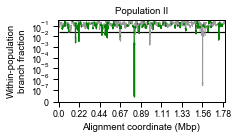

In [11]:
pop_1_phybreak = pd.read_table('../phybreak_result_0-1.txt')
plotdf_pop1, concat_pop1 = find_sweeps(pop_1_phybreak, outdf, p1, alpha, 'Pop1', pop1, 'Pop0', pop0, p0vp1)

final = concat_pop1[(concat_pop1.pop_pi < concat_pop1.ci_low) | (concat_pop1.pop_pi == 0)]
final.to_csv('sweep_results/population_0.1_sweeps.csv', index=None)

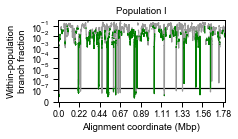

In [12]:
pop_0_phybreak = pd.read_table('../phybreak_result_0-0.txt')
plotdf_pop0, concat_pop0 = find_sweeps(pop_0_phybreak, outdf, p0, alpha, 'Pop0', pop0, 'Pop1', pop1, p0vp1)
final = concat_pop0[(concat_pop0.pop_pi < concat_pop0.ci_low) | (concat_pop0.pop_pi == 0)]
final.to_csv('sweep_results/population_0.0_sweeps.csv', index=None)

In [ ]:
stripplot_df